## Bitcoin Time series forecasting



### Import all library needed

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
import os

### Get data

In [ ]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/yogafatwanto/Bitcoin_time_series_forecasting/main/BTC_USD_2013-10-01_2021-05-18.csv

--2023-06-15 13:00:00--  https://raw.githubusercontent.com/yogafatwanto/Bitcoin_time_series_forecasting/main/BTC_USD_2013-10-01_2021-05-18.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 175721 (172K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18.csv.2’

BTC_USD_2013-10-01_ 100%[===================>] 171.60K  --.-KB/s    in 0.008s  

2023-06-15 13:00:00 (20.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18.csv.2’ saved [175721/175721]



In [ ]:
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


### Get the data info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


Because we told pandas to parse the date column and set it as the index, its not in the list of columns.

You can also see there isn't many samples.

In [ ]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of Bitcoin for the past ~8 years but there's only 2787 total samples.

In [ ]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


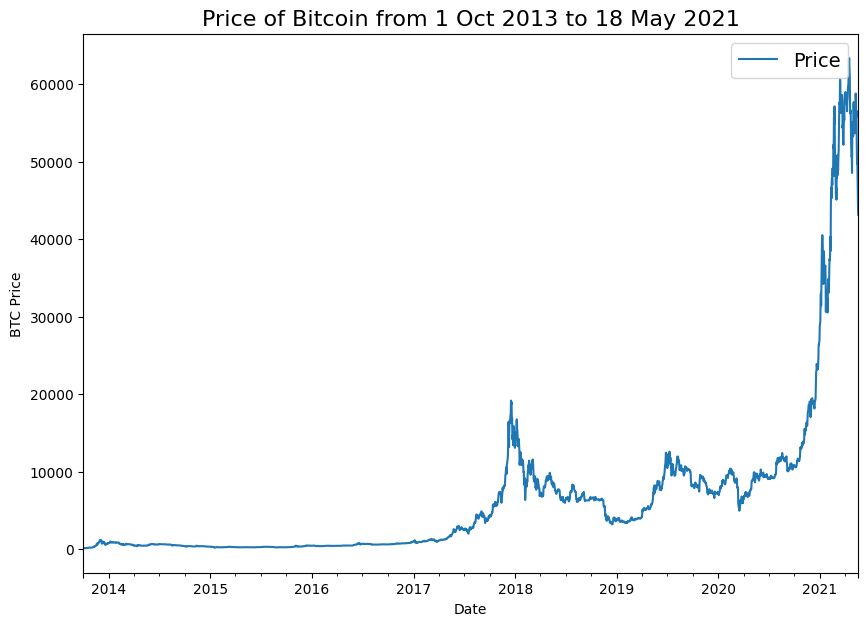

In [ ]:
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Format Data Part 1: Creatining train and test sets for time series data

In [ ]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

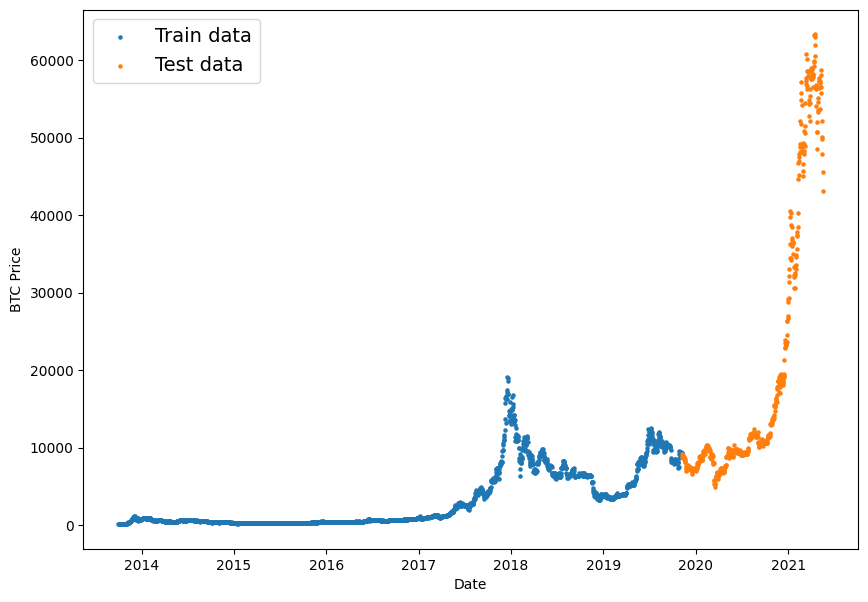

In [ ]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

Rather than retyping `matplotlib` commands to continuously plot data, let's make a plotting function we can reuse later.

In [ ]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).

  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

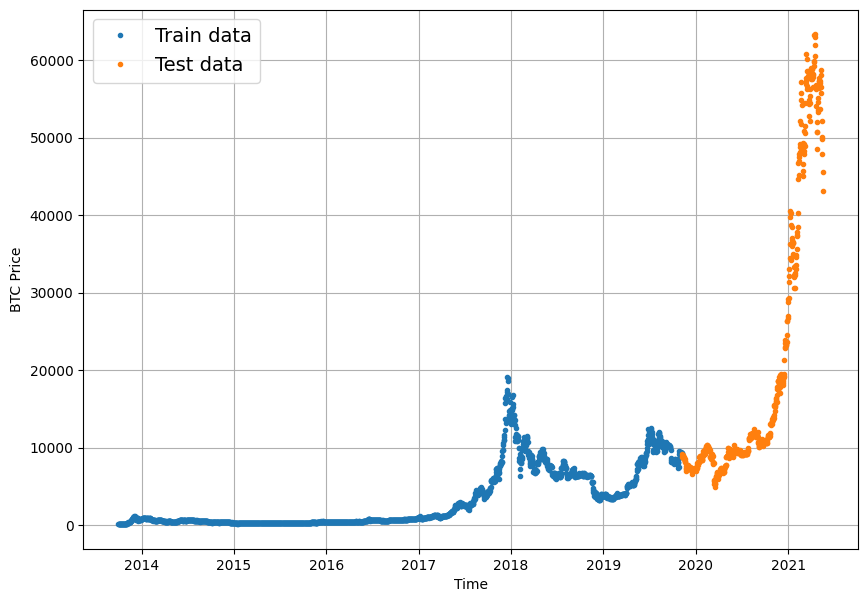

In [ ]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We can build almost any kind of model for our problem as long as the data inputs and outputs are formatted correctly.

However, just because we *can* build *almost any* kind of model, doesn't mean it'll perform well/should be used in a production setting.

We'll see what this means as we build and evaluate models throughout.

Before we discuss what modelling experiments we're going to run, there are two terms you should be familiar with, **horizon** and **window**.
  * **horizon** = number of timesteps to predict into future
  * **window** = number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and the window would be 7.

Now, how about those modelling experiments?

| Model Number | Model Type | Horizon size | Window size | Extra data |
| ----- | ----- | ----- | ----- | ----- |
| 0 | Naïve model (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | Same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | Same as 1 (but with multivariate data) | 1 | 7 | Block reward size |
| 7 | [N-BEATs Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |

## Model 0: Naïve forecast (baseline)

As usual, let's start with a baseline.

One of the most common baseline models for time series forecasting, the naïve model (also called the [naïve forecast](https://otexts.com/fpp3/simple-methods.html#na%C3%AFve-method)), requires no training at all.

That's because all the naïve model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$


> The prediction at timestep `t` (y-hat) is equal to the value at timestep `t-1` (the previous timestep).

In [ ]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

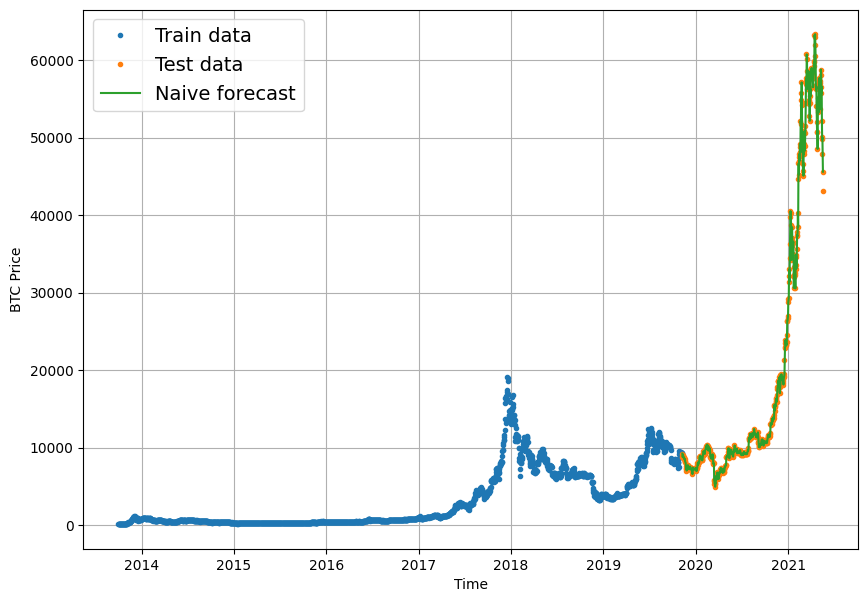

In [ ]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");

The naive forecast looks like it's following the data well.

Let's zoom in to take a better look.

We can do so by creating an offset value and passing it to the `start` parameter of our `plot_time_series()` function.

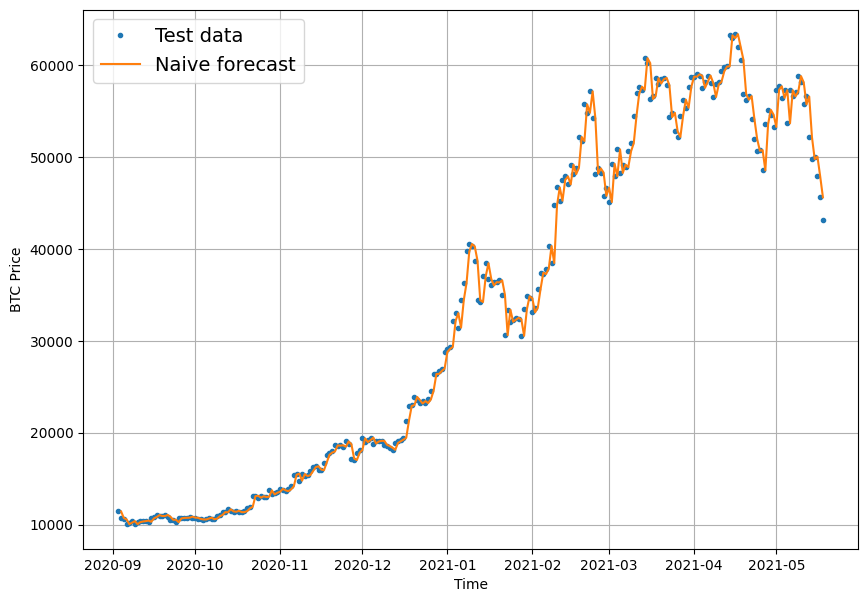

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

When we zoom in we see the naïve forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a time series model


| Metric | Details | Code |
| ----- | ----- | ----- |
| **MAE** (mean absolute error) | Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median. | [`tf.keras.metrics.mean_absolute_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/MeanAbsoluteError) |
| **RMSE** (root mean square error) | Forecasts which minimise the RMSE lead to forecasts of the mean. | `tf.sqrt(`[`tf.keras.metrics.mean_square_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError)`)`|

### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MAPE** (mean absolute percentage error) | Most commonly used percentage error. May explode (not work) if `y=0`. | [`tf.keras.metrics.mean_absolute_percentage_error()`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/MAPE) |
| **sMAPE** (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions. | Custom implementation |

### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| **Metric** | **Details** | **Code** |
| ----- | ----- | ----- |
| **MASE** (mean absolute scaled error). | MASE equals one for the naive forecast (or very close to one). A forecast which performs better than the naïve should get <1 MASE. | See sktime's [`mase_loss()`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |

In [ ]:
# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

You'll notice the version of MASE above doesn't take in the training values like sktime's `mae_loss()`. In our case, we're comparing the MAE of our predictions on the test to the MAE of the naïve forecast on the test set.

In practice, if we've created the function correctly, the naïve model should achieve an MASE of 1 (or very close to 1). Any model worse than the naïve forecast will achieve an MASE of >1 and any model better than the naïve forecast will achieve an MASE of <1.

Let's put each of our different evaluation metrics together into a function.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

Alright, looks like we've got some baselines to beat.

Taking a look at the naïve forecast's MAE, it seems on average each forecast is ~$567 different than the actual Bitcoin price.

How does this compare to the average price of Bitcoin in the test dataset?

In [ ]:
# Find average price of Bitcoin in test dataset
tf.reduce_mean(y_test).numpy()

20056.632963737222

Okay, looking at these two values is starting to give us an idea of how our model is performing:
* The average price of Bitcoin in the test dataset is: $20,056 (note: average may not be the best measure here, since the highest price is over 3x this value and the lowest price is over 4x lower)

* Each prediction in naive forecast is on average off by: $567

Is this enough to say it's a good model?

That's up your own interpretation. Personally, I'd prefer a model which was closer to the mark.

How about we try and build one?


## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| **Model/Library Name** | **Resource** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

### Format Data Part 2: Windowing dataset


We've got to window our time series.

Why do we window?

Windowing is a method to turn a time series dataset into **supervised learning problem**.

In other words, we want to use windows of the past to predict the future.

For example for a univariate time series, windowing for one week (`window=7`) to predict the next single value (`horizon=1`) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Or for the price of Bitcoin, it'd look like:

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

In [ ]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [ ]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [ ]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label: [43144.47129086]


### Turning windows into training and test sets

In [ ]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

### Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we'll want to make sure we're comparing apples to apples.

What I mean by this is in order for a fair comparison, we want to compare each model's best performance against each model's best performance.

For example, if `model_1` performed incredibly well on epoch 55 but its performance fell off toward epoch 100, we want the version of the model from epoch 55 to compare to other models rather than the version of the model from epoch 100.

And the same goes for each of our other models: compare the best against the best.

To take of this, we'll implement a [`ModelCheckpoint`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) callback.

The `ModelCheckpoint` callback will monitor our model's performance during training and save the best model to file by setting `save_best_only=True`.

That way when evaluating our model we could restore its best performing configuration from file.

In [ ]:
# Create a function to implement a ModelCheckpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

### Model 1: Dense model (window = 7, horizon = 1)

In [ ]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 783.2987 - mae: 783.2987    

18/18 [==============================] - 7s 48ms/step - loss: 774.2163 - mae: 774.2163 - val_loss: 1735.0856 - val_mae: 1735.0856
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 261.6353 - mae: 261.6353

18/18 [==============================] - 1s 31ms/step - loss: 259.9632 - mae: 259.9632 - val_loss: 1303.1353 - val_mae: 1303.1353
Epoch 3/100
12/18 [===================>..........] - ETA: 0s - loss: 220.6758 - mae: 220.6758

18/18 [==============================] - 1s 45ms/step - loss: 213.1365 - mae: 213.1365 - val_loss: 1097.9789 - val_mae: 1097.9789
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 191.8663 - mae: 191.8663

18/18 [==============================] - 1s 30ms/step - loss: 191.8663 - mae: 191.8663 - val_loss: 1078.6239 - val_mae: 1078.6239
Epoch 5/100
18/18 [==============================] - ETA: 0s - loss: 183.1210 - mae: 183.1210

18/18 [==============================] - 1s 31ms/step - loss: 183.1210 - mae: 183.1210 - val_loss: 991.4320 - val_mae: 991.4320
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 180.5391 - mae: 180.5391 - val_loss: 1016.6425 - val_mae: 1016.6425
Epoch 7/100
16/18 [=========================>....] - ETA: 0s - loss: 172.4662 - mae: 172.4662

18/18 [==============================] - 1s 31ms/step - loss: 168.3683 - mae: 168.3683 - val_loss: 905.6542 - val_mae: 905.6542
Epoch 8/100
18/18 [==============================] - ETA: 0s - loss: 162.5073 - mae: 162.5073

18/18 [==============================] - 1s 29ms/step - loss: 162.5073 - mae: 162.5073 - val_loss: 881.1158 - val_mae: 881.1158
Epoch 9/100
 1/18 [>.............................] - ETA: 0s - loss: 131.3297 - mae: 131.3297

18/18 [==============================] - 1s 31ms/step - loss: 160.1330 - mae: 160.1330 - val_loss: 842.6334 - val_mae: 842.6334
Epoch 10/100
17/18 [===========================>..] - ETA: 0s - loss: 152.9394 - mae: 152.9394

18/18 [==============================] - 1s 33ms/step - loss: 154.0138 - mae: 154.0138 - val_loss: 818.4760 - val_mae: 818.4760
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 146.9411 - mae: 146.9411 - val_loss: 906.1619 - val_mae: 906.1619
Epoch 12/100
18/18 [==============================] - 0s 6ms/step - loss: 145.7047 - mae: 145.7047 - val_loss: 878.1483 - val_mae: 878.1483
Epoch 13/100
18/18 [==============================] - ETA: 0s - loss: 142.7492 - mae: 142.7492

18/18 [==============================] - 1s 31ms/step - loss: 142.7492 - mae: 142.7492 - val_loss: 811.6996 - val_mae: 811.6996
Epoch 14/100
17/18 [===========================>..] - ETA: 0s - loss: 133.2555 - mae: 133.2555

18/18 [==============================] - 1s 32ms/step - loss: 135.6829 - mae: 135.6829 - val_loss: 774.0764 - val_mae: 774.0764
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 133.7999 - mae: 133.7999

18/18 [==============================] - 1s 30ms/step - loss: 135.3248 - mae: 135.3248 - val_loss: 741.3038 - val_mae: 741.3038
Epoch 16/100
18/18 [==============================] - ETA: 0s - loss: 129.9504 - mae: 129.9504

18/18 [==============================] - 1s 31ms/step - loss: 129.9504 - mae: 129.9504 - val_loss: 714.3768 - val_mae: 714.3768
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 129.9884 - mae: 129.9884 - val_loss: 748.7762 - val_mae: 748.7762
Epoch 18/100
18/18 [==============================] - ETA: 0s - loss: 128.8606 - mae: 128.8606

18/18 [==============================] - 1s 40ms/step - loss: 128.8606 - mae: 128.8606 - val_loss: 693.1472 - val_mae: 693.1472
Epoch 19/100
18/18 [==============================] - 0s 8ms/step - loss: 124.9676 - mae: 124.9676 - val_loss: 709.4860 - val_mae: 709.4860
Epoch 20/100
18/18 [==============================] - 0s 7ms/step - loss: 123.3291 - mae: 123.3291 - val_loss: 697.2770 - val_mae: 697.2770
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 126.7110 - mae: 126.7110

18/18 [==============================] - 1s 47ms/step - loss: 127.6103 - mae: 127.6103 - val_loss: 653.8479 - val_mae: 653.8479
Epoch 22/100
18/18 [==============================] - 0s 6ms/step - loss: 123.4947 - mae: 123.4947 - val_loss: 710.1714 - val_mae: 710.1714
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 131.3065 - mae: 131.3065 - val_loss: 746.1671 - val_mae: 746.1671
Epoch 24/100
 1/18 [>.............................] - ETA: 0s - loss: 138.6265 - mae: 138.6265

18/18 [==============================] - 1s 30ms/step - loss: 122.5514 - mae: 122.5514 - val_loss: 642.1113 - val_mae: 642.1113
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 118.3963 - mae: 118.3963

18/18 [==============================] - 1s 30ms/step - loss: 118.3963 - mae: 118.3963 - val_loss: 628.5277 - val_mae: 628.5277
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 117.1328 - mae: 117.1328

18/18 [==============================] - 1s 32ms/step - loss: 117.1328 - mae: 117.1328 - val_loss: 622.5709 - val_mae: 622.5709
Epoch 27/100
18/18 [==============================] - ETA: 0s - loss: 119.8543 - mae: 119.8543

18/18 [==============================] - 1s 46ms/step - loss: 119.8543 - mae: 119.8543 - val_loss: 622.4963 - val_mae: 622.4963
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 115.1377 - mae: 115.1377

18/18 [==============================] - 1s 30ms/step - loss: 115.1377 - mae: 115.1377 - val_loss: 619.7314 - val_mae: 619.7314
Epoch 29/100
 1/18 [>.............................] - ETA: 0s - loss: 115.2603 - mae: 115.2603

18/18 [==============================] - 1s 30ms/step - loss: 114.4773 - mae: 114.4773 - val_loss: 613.0701 - val_mae: 613.0701
Epoch 30/100
18/18 [==============================] - ETA: 0s - loss: 119.2483 - mae: 119.2483

18/18 [==============================] - 1s 30ms/step - loss: 119.2483 - mae: 119.2483 - val_loss: 610.9638 - val_mae: 610.9638
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 111.6111 - mae: 111.6111 - val_loss: 625.1931 - val_mae: 625.1931
Epoch 32/100
18/18 [==============================] - ETA: 0s - loss: 112.1233 - mae: 112.1233

18/18 [==============================] - 1s 31ms/step - loss: 112.1233 - mae: 112.1233 - val_loss: 603.1594 - val_mae: 603.1594
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 113.2986 - mae: 113.2986 - val_loss: 666.9755 - val_mae: 666.9755
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4558 - mae: 112.4558 - val_loss: 604.8262 - val_mae: 604.8262
Epoch 35/100
18/18 [==============================] - ETA: 0s - loss: 109.8000 - mae: 109.8000

18/18 [==============================] - 1s 32ms/step - loss: 109.8000 - mae: 109.8000 - val_loss: 593.5057 - val_mae: 593.5057
Epoch 36/100
18/18 [==============================] - 0s 6ms/step - loss: 112.3721 - mae: 112.3721 - val_loss: 606.6368 - val_mae: 606.6368
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3334 - mae: 111.3334 - val_loss: 601.2146 - val_mae: 601.2146
Epoch 38/100
18/18 [==============================] - 0s 5ms/step - loss: 112.0345 - mae: 112.0345 - val_loss: 624.8445 - val_mae: 624.8445
Epoch 39/100
16/18 [=========================>....] - ETA: 0s - loss: 112.0333 - mae: 112.0333

18/18 [==============================] - 1s 31ms/step - loss: 109.7221 - mae: 109.7221 - val_loss: 587.4327 - val_mae: 587.4327
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 108.5752 - mae: 108.5752 - val_loss: 602.1580 - val_mae: 602.1580
Epoch 41/100
 1/18 [>.............................] - ETA: 0s - loss: 106.4937 - mae: 106.4937

18/18 [==============================] - 1s 31ms/step - loss: 108.1969 - mae: 108.1969 - val_loss: 579.6310 - val_mae: 579.6310
Epoch 42/100
18/18 [==============================] - 0s 6ms/step - loss: 115.2885 - mae: 115.2885 - val_loss: 671.9643 - val_mae: 671.9643
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 121.9438 - mae: 121.9438 - val_loss: 668.9845 - val_mae: 668.9845
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 119.7562 - mae: 119.7562

18/18 [==============================] - 1s 30ms/step - loss: 119.7562 - mae: 119.7562 - val_loss: 576.4644 - val_mae: 576.4644
Epoch 45/100
18/18 [==============================] - 0s 6ms/step - loss: 108.7479 - mae: 108.7479 - val_loss: 595.5675 - val_mae: 595.5675
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 108.0060 - mae: 108.0060 - val_loss: 653.7241 - val_mae: 653.7241
Epoch 47/100
18/18 [==============================] - ETA: 0s - loss: 113.4451 - mae: 113.4451

18/18 [==============================] - 1s 32ms/step - loss: 113.4451 - mae: 113.4451 - val_loss: 576.1173 - val_mae: 576.1173
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 110.5486 - mae: 110.5486 - val_loss: 696.9232 - val_mae: 696.9232
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 123.7322 - mae: 123.7322 - val_loss: 596.4601 - val_mae: 596.4601
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 107.6610 - mae: 107.6610 - val_loss: 670.2385 - val_mae: 670.2385
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 113.3275 - mae: 113.3275 - val_loss: 620.9996 - val_mae: 620.9996
Epoch 52/100
18/18 [==============================] - 0s 6ms/step - loss: 112.0266 - mae: 112.0266 - val_loss: 578.3956 - val_mae: 578.3956
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6254 - mae: 111.6254 - val_loss: 645.5623 - val_mae: 645.5623
Epoch 54/100
 1/18 [>...........

18/18 [==============================] - 1s 31ms/step - loss: 113.5267 - mae: 113.5267 - val_loss: 569.9816 - val_mae: 569.9816
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6478 - mae: 111.6478 - val_loss: 572.5648 - val_mae: 572.5648
Epoch 56/100
18/18 [==============================] - 0s 6ms/step - loss: 106.3221 - mae: 106.3221 - val_loss: 758.7182 - val_mae: 758.7182
Epoch 57/100
18/18 [==============================] - 0s 8ms/step - loss: 118.0415 - mae: 118.0415 - val_loss: 577.2925 - val_mae: 577.2925
Epoch 58/100
18/18 [==============================] - 0s 8ms/step - loss: 112.5284 - mae: 112.5284 - val_loss: 623.5498 - val_mae: 623.5498
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 109.3500 - mae: 109.3500 - val_loss: 637.8872 - val_mae: 637.8872
Epoch 60/100
18/18 [==============================] - 0s 8ms/step - loss: 113.7975 - mae: 113.7975 - val_loss: 652.3448 - val_mae: 652.3448
Epoch 61/100
18/18 [============

18/18 [==============================] - 1s 42ms/step - loss: 105.8115 - mae: 105.8115 - val_loss: 568.9860 - val_mae: 568.9860
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 106.1514 - mae: 106.1514 - val_loss: 602.7841 - val_mae: 602.7841
Epoch 65/100
18/18 [==============================] - ETA: 0s - loss: 108.3822 - mae: 108.3822

18/18 [==============================] - 1s 30ms/step - loss: 108.3822 - mae: 108.3822 - val_loss: 568.9401 - val_mae: 568.9401
Epoch 66/100
18/18 [==============================] - ETA: 0s - loss: 105.0362 - mae: 105.0362

18/18 [==============================] - 1s 32ms/step - loss: 105.0362 - mae: 105.0362 - val_loss: 565.2192 - val_mae: 565.2192
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 105.7962 - mae: 105.7962 - val_loss: 630.4250 - val_mae: 630.4250
Epoch 68/100
18/18 [==============================] - 0s 6ms/step - loss: 107.7970 - mae: 107.7970 - val_loss: 567.6861 - val_mae: 567.6861
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 112.5736 - mae: 112.5736 - val_loss: 698.4675 - val_mae: 698.4675
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 123.9685 - mae: 123.9685 - val_loss: 571.2595 - val_mae: 571.2595
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 108.5705 - mae: 108.5705 - val_loss: 567.1677 - val_mae: 567.1677
Epoch 72/100
18/18 [==============================] - 0s 6ms/step - loss: 112.4437 - mae: 112.4437 - val_loss: 588.1379 - val_mae: 588.1379
Epoch 73/100
18/18 [============

18/18 [==============================] - 1s 45ms/step - loss: 104.9787 - mae: 104.9787 - val_loss: 564.2616 - val_mae: 564.2616
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 109.6425 - mae: 109.6425 - val_loss: 567.3417 - val_mae: 567.3417
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 120.3913 - mae: 120.3913 - val_loss: 737.9504 - val_mae: 737.9504


In [ ]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 737.9506 - mae: 737.9506


[737.9506225585938, 737.9506225585938]

You'll notice the model achieves the same `val_loss` (in this case, this is MAE) as the last epoch.

But if we load in the version of `model_1` which was saved to file using the `ModelCheckpoint` callback, we should see an improvement in results.

In [ ]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 564.2617 - mae: 564.2617


[564.2616577148438, 564.2616577148438]

## Making forecasts with a model (on the test dataset)

We've trained a model and evaluated the it on the test data, but the project we're working on is called BitPredict 💰📈 so how do you think we could use our model to make predictions?

Since we're going to be running more modelling experiments, let's write a function which:
1. Takes in a trained model (just like `model_1`)
2. Takes in some input data (just like the data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions



In [ ]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [ ]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8838.901 , 8786.515 , 9060.807 , 8760.5   , 8742.9375, 8757.063 ,
        8676.358 , 8516.724 , 8469.286 , 8537.618 ], dtype=float32)>)

In [ ]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 564.26166,
 'mse': 1152364.0,
 'rmse': 1073.4822,
 'mape': 2.5305781,
 'mase': 0.99125147}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

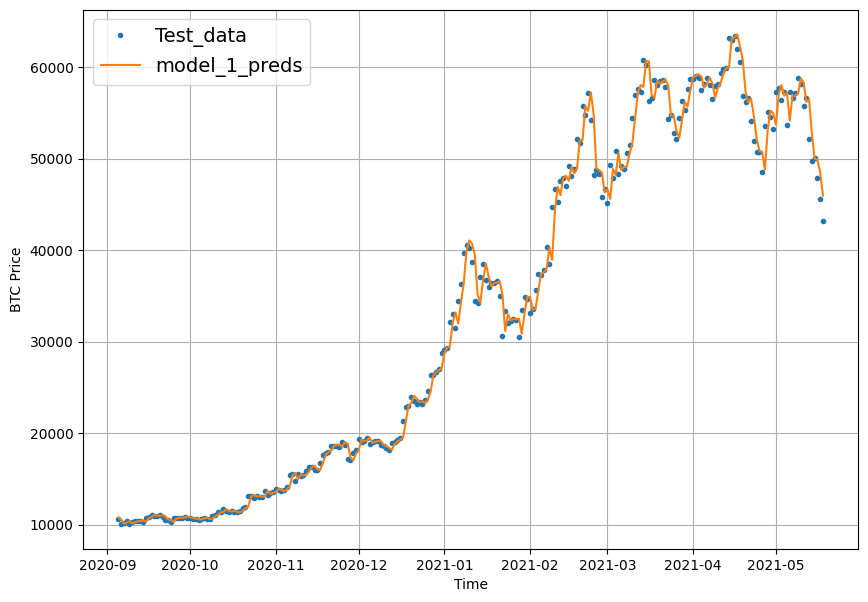

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [ ]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in the past

In [ ]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
 1/18 [>.............................] - ETA: 13s - loss: 2330.5400

18/18 [==============================] - 1s 36ms/step - loss: 935.3506 - val_loss: 2237.5554
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 519.0287

18/18 [==============================] - 1s 30ms/step - loss: 506.3103 - val_loss: 1913.6740
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 423.6610

18/18 [==============================] - 1s 43ms/step - loss: 369.9310 - val_loss: 1718.1733
Epoch 4/100
14/18 [======================>.......] - ETA: 0s - loss: 320.3315

18/18 [==============================] - 1s 44ms/step - loss: 313.5579 - val_loss: 1456.6880
Epoch 5/100
12/18 [===================>..........] - ETA: 0s - loss: 269.8463

18/18 [==============================] - 1s 36ms/step - loss: 266.0084 - val_loss: 1345.3615
Epoch 6/100
 1/18 [>.............................] - ETA: 0s - loss: 302.7409

18/18 [==============================] - 0s 28ms/step - loss: 267.8397 - val_loss: 1313.4336
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 230.8385

18/18 [==============================] - 0s 29ms/step - loss: 239.7538 - val_loss: 1131.1742
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 210.3497

18/18 [==============================] - 1s 46ms/step - loss: 213.1351 - val_loss: 1096.9240
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 211.8649 - val_loss: 1298.7111
Epoch 10/100
18/18 [==============================] - 0s 5ms/step - loss: 213.4480 - val_loss: 1107.3610
Epoch 11/100
16/18 [=========================>....] - ETA: 0s - loss: 187.7208

18/18 [==============================] - 1s 32ms/step - loss: 186.8778 - val_loss: 971.3145
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 173.8773 - val_loss: 1010.4053
Epoch 13/100
18/18 [==============================] - 0s 5ms/step - loss: 169.6051 - val_loss: 1174.0453
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 254.9568

18/18 [==============================] - 1s 30ms/step - loss: 166.8344 - val_loss: 834.1749
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 189.9900

18/18 [==============================] - 1s 30ms/step - loss: 156.0053 - val_loss: 810.2113
Epoch 16/100
 1/18 [>.............................] - ETA: 0s - loss: 147.8327

18/18 [==============================] - 0s 28ms/step - loss: 171.9328 - val_loss: 790.2019
Epoch 17/100
18/18 [==============================] - 0s 5ms/step - loss: 157.4597 - val_loss: 1078.9617
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 162.6984 - val_loss: 801.7577
Epoch 19/100
18/18 [==============================] - 0s 5ms/step - loss: 144.3042 - val_loss: 1332.5557
Epoch 20/100
 1/18 [>.............................] - ETA: 0s - loss: 228.0874

18/18 [==============================] - 1s 30ms/step - loss: 162.7978 - val_loss: 780.7299
Epoch 21/100
18/18 [==============================] - 0s 5ms/step - loss: 157.0216 - val_loss: 1363.6292
Epoch 22/100
18/18 [==============================] - ETA: 0s - loss: 205.0619

18/18 [==============================] - 1s 31ms/step - loss: 205.0619 - val_loss: 747.3284
Epoch 23/100
18/18 [==============================] - 0s 6ms/step - loss: 154.1872 - val_loss: 1170.2501
Epoch 24/100
18/18 [==============================] - 0s 5ms/step - loss: 151.3527 - val_loss: 773.4520
Epoch 25/100
18/18 [==============================] - ETA: 0s - loss: 147.8446

18/18 [==============================] - 1s 32ms/step - loss: 147.8446 - val_loss: 718.3723
Epoch 26/100
18/18 [==============================] - 0s 6ms/step - loss: 145.8781 - val_loss: 890.3745
Epoch 27/100
18/18 [==============================] - 0s 5ms/step - loss: 138.3106 - val_loss: 721.2482
Epoch 28/100
18/18 [==============================] - 0s 5ms/step - loss: 149.4422 - val_loss: 846.0432
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 141.8612 - val_loss: 1279.2056
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 159.0718 - val_loss: 885.5426
Epoch 31/100
 1/18 [>.............................] - ETA: 0s - loss: 153.0809

18/18 [==============================] - 1s 31ms/step - loss: 152.7056 - val_loss: 693.9687
Epoch 32/100
18/18 [==============================] - 0s 5ms/step - loss: 154.5549 - val_loss: 1310.7242
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 157.2348 - val_loss: 797.8599
Epoch 34/100
18/18 [==============================] - 0s 5ms/step - loss: 140.4422 - val_loss: 740.0066
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 132.6528 - val_loss: 760.3923
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 146.4725

18/18 [==============================] - 1s 29ms/step - loss: 132.0877 - val_loss: 680.9969
Epoch 37/100
 1/18 [>.............................] - ETA: 0s - loss: 134.9130

18/18 [==============================] - 1s 32ms/step - loss: 142.3697 - val_loss: 679.5097
Epoch 38/100
18/18 [==============================] - 0s 4ms/step - loss: 129.5995 - val_loss: 801.9988
Epoch 39/100
18/18 [==============================] - 0s 5ms/step - loss: 130.5735 - val_loss: 794.7639
Epoch 40/100
18/18 [==============================] - 0s 5ms/step - loss: 135.1061 - val_loss: 769.3179
Epoch 41/100
18/18 [==============================] - 0s 5ms/step - loss: 127.8074 - val_loss: 694.0581
Epoch 42/100
18/18 [==============================] - 0s 5ms/step - loss: 126.0904 - val_loss: 886.1683
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 134.5886 - val_loss: 705.2093
Epoch 44/100
18/18 [==============================] - 0s 8ms/step - loss: 147.9346 - val_loss: 700.8857
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 125.6131 - val_loss: 727.7392
Epoch 46/100
18/18 [==============================] - 0s 8ms/step - loss: 14

18/18 [==============================] - 1s 39ms/step - loss: 136.8288 - val_loss: 656.3635
Epoch 53/100
18/18 [==============================] - 0s 5ms/step - loss: 129.0131 - val_loss: 810.2920
Epoch 54/100
18/18 [==============================] - 0s 5ms/step - loss: 142.2865 - val_loss: 1071.0729
Epoch 55/100
18/18 [==============================] - 0s 5ms/step - loss: 159.4772 - val_loss: 1089.5508
Epoch 56/100
18/18 [==============================] - ETA: 0s - loss: 134.2118

18/18 [==============================] - 1s 31ms/step - loss: 134.2118 - val_loss: 646.1896
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4605 - val_loss: 1080.6975
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 142.7632 - val_loss: 885.6516
Epoch 59/100
18/18 [==============================] - 0s 5ms/step - loss: 183.9792 - val_loss: 657.7321
Epoch 60/100
 1/18 [>.............................] - ETA: 0s - loss: 120.1737

18/18 [==============================] - 1s 30ms/step - loss: 119.9082 - val_loss: 631.1428
Epoch 61/100
 1/18 [>.............................] - ETA: 0s - loss: 111.8430

18/18 [==============================] - 0s 29ms/step - loss: 124.9534 - val_loss: 622.3411
Epoch 62/100
18/18 [==============================] - 0s 5ms/step - loss: 133.6859 - val_loss: 626.2724
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 144.1159 - val_loss: 707.5464
Epoch 64/100
18/18 [==============================] - 0s 6ms/step - loss: 120.0728 - val_loss: 722.2529
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 127.3964 - val_loss: 678.5622
Epoch 66/100
18/18 [==============================] - 0s 5ms/step - loss: 121.0938 - val_loss: 782.5570
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 125.1552 - val_loss: 624.5931
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 116.2618 - val_loss: 773.6559
Epoch 69/100
18/18 [==============================] - 0s 5ms/step - loss: 126.8435 - val_loss: 1031.5392
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 200.1

18/18 [==============================] - 1s 30ms/step - loss: 133.9631 - val_loss: 615.9236
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 134.4360 - val_loss: 802.9216
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 139.3592 - val_loss: 1012.8818
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 172.4097 - val_loss: 915.4605
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 148.1170 - val_loss: 1317.2010
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 138.5567 - val_loss: 656.4855
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 120.2571 - val_loss: 716.7490
Epoch 77/100
18/18 [==============================] - 0s 5ms/step - loss: 124.1540 - val_loss: 768.4256
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4954 - val_loss: 627.5315
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 

18/18 [==============================] - 1s 49ms/step - loss: 120.8330 - val_loss: 615.5977
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 127.5008 - val_loss: 675.1037


In [ ]:
# Evaluate model 2 preds
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 675.1037


675.1036987304688

In [ ]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 615.5978


615.5978393554688

In [ ]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [ ]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 615.59784,
 'mse': 1333238.4,
 'rmse': 1154.6594,
 'mape': 2.782414,
 'mase': 1.076071}

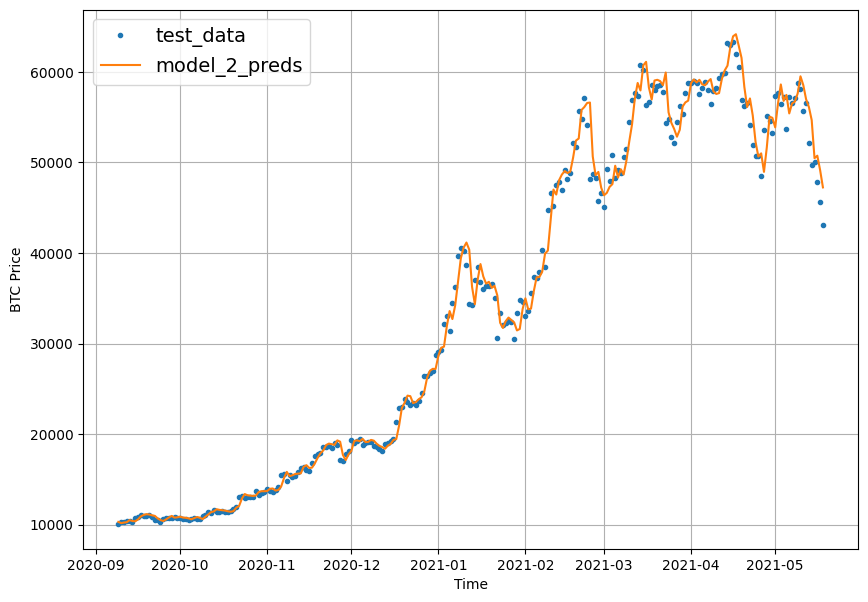

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3: Dense (window = 30, horizon = 7)

Let's try and predict 7 days ahead given the previous 30 days.

First, we'll update the `HORIZON` and `WINDOW_SIZE` variables and create windowed data.


In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
# How did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1295.7183


1295.71826171875

In [ ]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1217.6348


1217.634765625

In this case, the error will be higher because we're predicting 7 steps at a time.

This makes sense though because the further you try and predict, the larger your error will be (think of trying to predict the weather 7 days in advance).

Let's make predictions with our model using the `make_preds()` function and evaluate them using the `evaluate_preds()` function.

In [ ]:
# The predictions are going to be 7 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9458.353 , 9238.82  , 9508.843 , 9409.79  , 9291.1875, 9426.278 ,
        9559.643 ],
       [9137.57  , 8873.596 , 9094.722 , 9031.631 , 9042.155 , 9174.632 ,
        9282.971 ],
       [8900.684 , 8711.719 , 8793.085 , 8865.098 , 9114.933 , 8902.521 ,
        9129.584 ],
       [9082.078 , 8967.77  , 8945.197 , 9165.996 , 9433.144 , 9178.872 ,
        9280.321 ],
       [8819.856 , 8968.566 , 8912.707 , 8876.77  , 9107.868 , 9101.342 ,
        9043.824 ]], dtype=float32)>

In [ ]:
# Calculate model_3 results - these are going to be multi-dimensional because
# we're trying to predict more than one step at a time.
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([ 620.0585  ,  399.09543 ,  264.0886  ,  523.888   ,  421.49985 ,
         506.66287 ,  610.162   ,  550.22455 ,  586.1947  ,  481.40408 ,
         666.3364  ,  782.2425  ,  789.57526 ,  941.3451  ,  669.32    ,
         217.69594 ,  204.29207 ,  346.77133 ,  288.22467 ,  314.0872  ,
         125.543526,  180.45207 ,  338.2816  ,  249.56752 ,  180.3702  ,
         102.9149  ,  111.15318 ,  138.1905  ,  107.95717 ,  181.01576 ,
         298.77512 ,  344.75677 ,  316.70926 ,  290.37662 ,  264.57632 ,
         225.86537 ,  306.68832 ,  285.99713 ,  194.87988 ,  210.53781 ,
         460.42697 ,   85.31132 ,   86.15053 ,   64.51367 ,  157.27176 ,
         103.16344 ,  124.143   ,  120.908134,  105.72572 ,  118.356026,
         119.5768  ,  112.86503 ,  238.43352 ,  222.57959 ,  233.21701 ,
         319.4445  ,  537.702   ,  497.5078  ,  450.94406 ,  537.3276  ,
         257.20697 ,  198.73389 ,  312.47787 ,  346.21793 ,  447.41922 ,
         433.55887 ,  493.32428 ,  494.61978

## Make our evaluation function work for larger horizons

You'll notice the outputs for `model_3_results` are multi-dimensional.

This is because the predictions are getting evaluated across the `HORIZON` timesteps (7 predictions at a time).

To fix this, let's adjust our `evaluate_preds()` function to work with multiple shapes of data.

In [ ]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [ ]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1217.6345,
 'mse': 5221397.0,
 'rmse': 1400.255,
 'mape': 5.472565,
 'mase': 2.1667125}

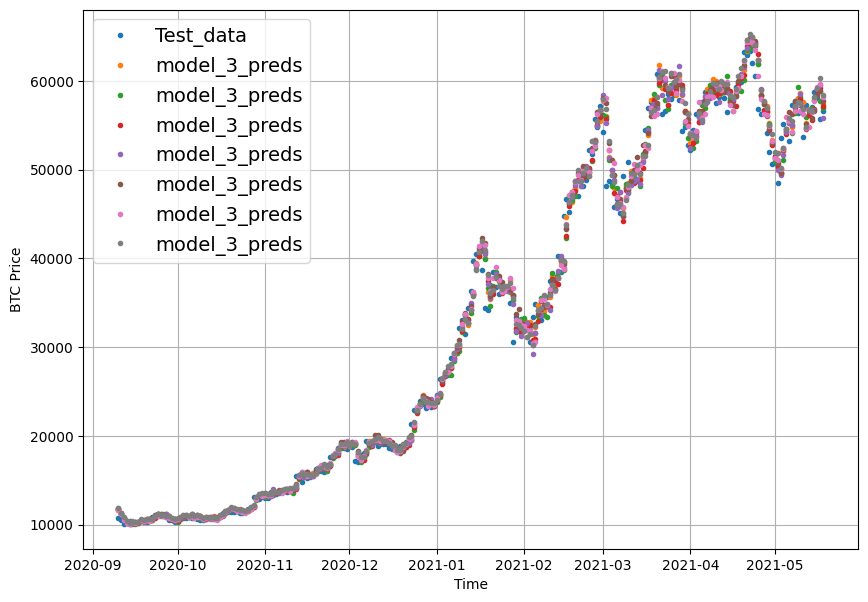

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

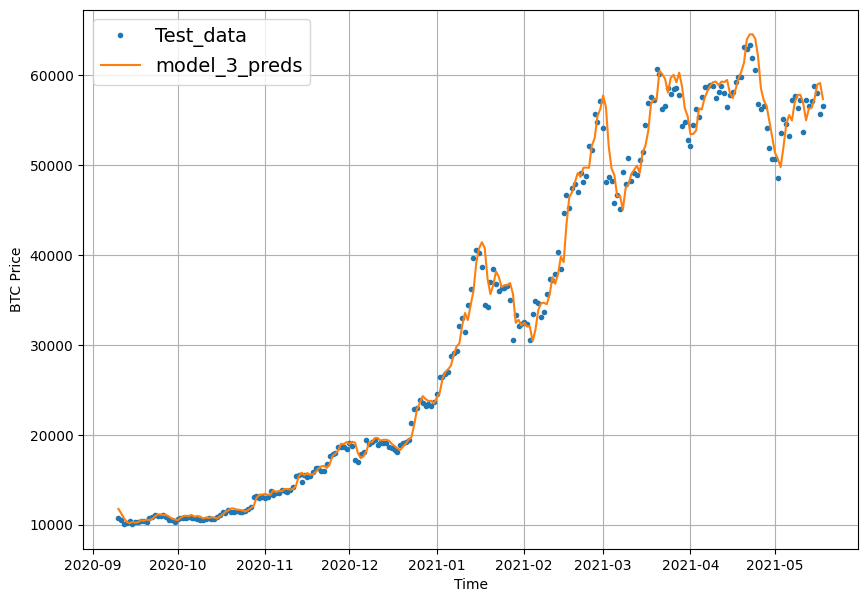

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:, 0],
                 start=offset,
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=tf.reduce_mean(model_3_preds, axis=1),
                 format="-",
                 start=offset,
                 label="model_3_preds")

## Which of our models is performing best so far?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naïve model to see which model is performing the best so far.

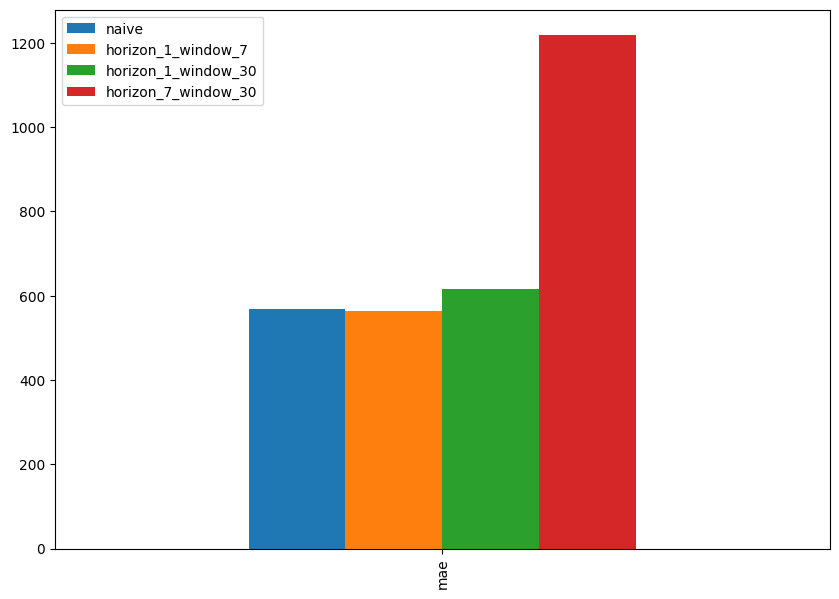

In [ ]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

Onto the next modelling experiment!

This time, we'll be using a Conv1D model. Because as we saw in the sequence modelling notebook, Conv1D models can be used for seq2seq (sequence to sequence) problems.

In our case, the input sequence is the previous 7 days of Bitcoin price data and the output is the next day (in seq2seq terms this is called a many to one problem).

In [ ]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [ ]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [ ]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

Data windowed!

Now, since we're going to be using [Conv1D layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D), we need to make sure our input shapes are correct.

The Conv1D layer in TensorFlow takes an input of: `(batch_size, timesteps, input_dim)`.

In our case, the `batch_size` (by default this is 32 but we can change it) is handled for us but the other values will be:
* `timesteps = WINDOW_SIZE` - the `timesteps` is also often referred to as `features`, our features are the previous `WINDOW_SIZE` values of Bitcoin
* `input_dim = HORIZON` - our model views `WINDOW_SIZE` (one week) worth of data at a time to predict `HORIZON` (one day)

Right now, our data has the `timesteps` dimension ready but we'll have to adjust it to have the `input_dim` dimension.

In [ ]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

To fix this, we could adjust the shape of all of our `train_windows` or we could use a [`tf.keras.layers.Lamdba`](https://keras.io/api/layers/core_layers/lambda/) (called a Lambda layer) to do this for us in our model.

The Lambda layer wraps a function into a layer which can be used with a model.

Let's try it out.

In [ ]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_8 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 574.4231


574.423095703125

In [ ]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8903.695 , 8781.364 , 9019.023 , 8804.0205, 8731.909 , 8766.223 ,
       8696.595 , 8518.386 , 8485.332 , 8524.403 ], dtype=float32)>

In [ ]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 574.4231,
 'mse': 1191376.6,
 'rmse': 1091.502,
 'mape': 2.566289,
 'mase': 1.0091022}

### Model 5: RNN (LSTM)

As you might've guessed, we can also use a recurrent neural network to model our sequential time series data.


Let's reuse the same data we used for the Conv1D model, except this time we'll create an [LSTM-cell](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) powered RNN to model our Bitcoin data.

Once again, one of the most important steps for the LSTM model will be getting our data into the right shape.

The [`tf.keras.layers.LSTM()`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) layer takes a tensor with `[batch, timesteps, feature]` dimensions.

As mentioned earlier, the `batch` dimension gets taken care of for us but our data is currently only has the `feature` dimension (`WINDOW_SIZE`).

To fix this, just like we did with the `Conv1D` model, we can use a `tf.keras.layers.Lambda()` layer to adjust the shape of our input tensors to the LSTM layer.








In [ ]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 5s 168ms/step - loss: 2193.1904 - val_loss: 7458.3320
Epoch 2/100
18/18 [==============================] - 2s 109ms/step - loss: 539.6313 - val_loss: 1802.6953
Epoch 3/100
18/18 [==============================] - 2s 105ms/step - loss: 239.6051 - val_loss: 1371.7073
Epoch 4/100
18/18 [==============================] - 2s 109ms/step - loss: 181.8084 - val_loss: 974.1002
Epoch 5/100
18/18 [==============================] - 2s 106ms/step - loss: 173.6885 - val_loss: 968.6596
Epoch 6/100
18/18 [==============================] - 3s 153ms/step - loss: 162.6876 - val_loss: 905.7278
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 166.3487 - val_loss: 970.5009
Epoch 8/100
18/18 [==============================] - 0s 14ms/step - loss: 169.3480 - val_loss: 969.5533
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 167.9317 - val_loss: 971.4022
Epoch 10/100
18/18 [==============================] - 0

In [ ]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 586.2066


586.2066040039062

Now we've got the best performing LSTM model loaded in, let's make predictions with it and evaluate them.

In [ ]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8960.935, 8825.43 , 8994.076, 8811.04 , 8759.489, 8768.386,
       8712.17 , 8562.02 , 8493.756, 8531.989], dtype=float32)>

In [ ]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 586.2066,
 'mse': 1237763.6,
 'rmse': 1112.5482,
 'mape': 2.6414886,
 'mase': 1.0298027}

## Make a multivariate time series

So far all of our models have barely kept up with the naïve forecast.

And so far all of them have been trained on a single variable (also called univariate time series): the historical price of Bitcoin.

If predicting the price of Bitcoin using the price of Bitcoin hasn't worked out very well, maybe giving our model more information may help.

More information is a vague term because we could actually feed almost anything to our model(s) and they would still try to find patterns.

For example, we could use the historical price of Bitcoin as well as anyone with the name [Daniel Bourke Tweeted](https://twitter.com/mrdbourke) on that day to predict the future price of Bitcoin.

But would this help?

Porbably not.

What would be better is if we passed our model something related to Bitcoin (again, this is quite vauge, since in an open system like a market, you could argue everything is related).

This will be different for almost every time series you work on but in our case, we could try to see if the [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) adds any predictive power to our model(s).

What is the Bitcoin block reward size?

The Bitcoin block reward size is the number of Bitcoin someone receives from mining a Bitcoin block.

At its inception, the Bitcoin block reward size was 50.

But every four years or so, the Bitcoin block reward halves.

For example, the block reward size went from 50 (starting January 2009) to 25 on November 28 2012.

In [ ]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


Alright, time to add another feature column, the block reward size.

First, we'll need to create variables for the different block reward sizes as well as the dates they came into play.

The following block rewards and dates were sourced from [cmcmarkets.com](https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving).

| Block Reward | Start Date |
| ----- | ----- |
| 50 | 3 January 2009 (2009-01-03) |
| 25 | 28 November 2012 |
| 12.5 | 9 July 2016 |
| 6.25 | 11 May 2020 |
| 3.125 | TBA (expected 2024) |
| 1.5625 | TBA (expected 2028) |

Since our Bitcoin historical data starts from 01 October 2013, none of the timesteps in our multivariate time series will have a block reward of 50.

In [ ]:
# Block reward values
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - this block reward isn't in our dataset (it starts from 01 October 2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (datetime form of the above date stamps)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Get date indexes for when to add in different block dates
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Add block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block_reward column (it's the last column hence -1 indexing on iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


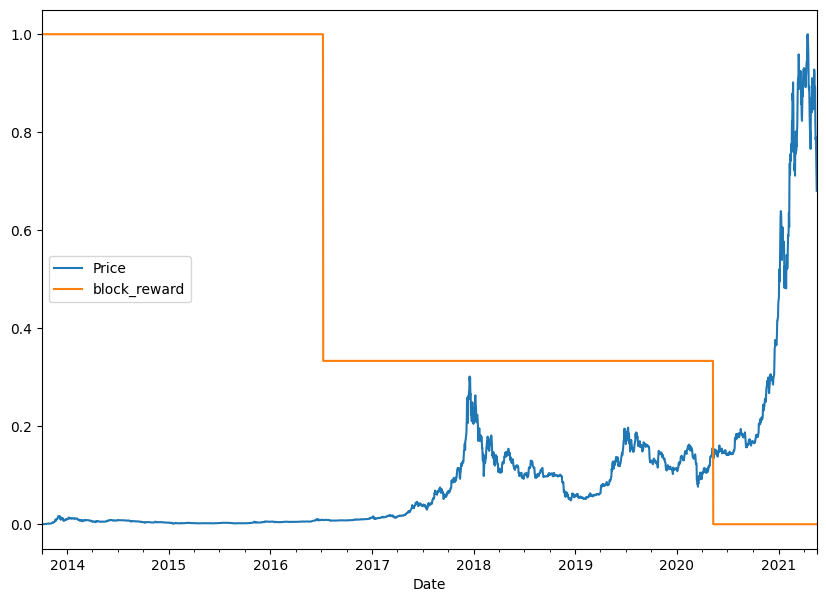

In [ ]:
# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

## Making a windowed dataset with pandas

Previously, we used some custom made functions to window our **univariate** time series.

However, since we've just added another variable to our dataset, these functions won't work.

Not to worry though. Since our data is in a pandas DataFrame, we can leverage the [`pandas.DataFrame.shift()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.shift.html) method to create a windowed **multivariate** time series.

The `shift()` method offsets an index by a specified number of periods.

Let's see it in action.

In [ ]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Now that we've got a windowed dataset, let's separate features (`X`) from labels (`y`).

Remember in our windowed dataset, we're trying to use the previous `WINDOW_SIZE` steps to predict `HORIZON` steps.

```
Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON

[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

We'll also remove the `NaN` values using pandas [`dropna()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html) method, this equivalent to starting our windowing function at `sample 0 (the first sample) + WINDOW_SIZE`.

In [ ]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [ ]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

To keep things simple, let's the `model_1` architecture and use it to train and make predictions on our multivariate time series data.

By replicating the `model_1` architecture we'll be able to see whether or not adding the block reward feature improves or detracts from model performance.

In [ ]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1562.7761 

18/18 [==============================] - 1s 39ms/step - loss: 1535.2720 - val_loss: 2326.9285
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 390.4173

18/18 [==============================] - 1s 30ms/step - loss: 387.4078 - val_loss: 1963.8114
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 267.1544

18/18 [==============================] - 1s 51ms/step - loss: 229.1227 - val_loss: 1359.4141
Epoch 4/100
 1/18 [>.............................] - ETA: 0s - loss: 258.8420

18/18 [==============================] - 1s 32ms/step - loss: 190.3278 - val_loss: 1085.7292
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 180.7766

18/18 [==============================] - 1s 31ms/step - loss: 178.8221 - val_loss: 976.2559
Epoch 6/100
15/18 [========================>.....] - ETA: 0s - loss: 174.9362

18/18 [==============================] - 1s 31ms/step - loss: 174.7765 - val_loss: 936.3494
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 208.6550

18/18 [==============================] - 1s 31ms/step - loss: 164.3199 - val_loss: 897.2429
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 134.0084

18/18 [==============================] - 1s 30ms/step - loss: 158.7117 - val_loss: 873.4226
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 157.1464 - val_loss: 880.7524
Epoch 10/100
18/18 [==============================] - ETA: 0s - loss: 153.3068

18/18 [==============================] - 1s 30ms/step - loss: 153.3068 - val_loss: 830.8760
Epoch 11/100
18/18 [==============================] - 0s 5ms/step - loss: 149.8585 - val_loss: 839.9080
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 146.8114 - val_loss: 839.9839
Epoch 13/100
 1/18 [>.............................] - ETA: 0s - loss: 119.4457

18/18 [==============================] - 1s 29ms/step - loss: 145.1886 - val_loss: 815.9197
Epoch 14/100
 1/18 [>.............................] - ETA: 0s - loss: 148.6957

18/18 [==============================] - 1s 29ms/step - loss: 139.5276 - val_loss: 775.5843
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 142.1816

18/18 [==============================] - 1s 30ms/step - loss: 140.7532 - val_loss: 753.0671
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 135.0931 - val_loss: 767.3436
Epoch 17/100
18/18 [==============================] - 0s 6ms/step - loss: 134.0200 - val_loss: 771.6298
Epoch 18/100
 1/18 [>.............................] - ETA: 0s - loss: 154.4623

18/18 [==============================] - 0s 29ms/step - loss: 134.2328 - val_loss: 733.4844
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 131.8981 - val_loss: 736.5825
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 131.5338

18/18 [==============================] - 1s 36ms/step - loss: 131.5338 - val_loss: 718.0353
Epoch 21/100
13/18 [====================>.........] - ETA: 0s - loss: 132.0085

18/18 [==============================] - 1s 43ms/step - loss: 133.2747 - val_loss: 700.8079
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 128.8907 - val_loss: 706.8647
Epoch 23/100
13/18 [====================>.........] - ETA: 0s - loss: 126.8092

18/18 [==============================] - 1s 34ms/step - loss: 128.6756 - val_loss: 687.5944
Epoch 24/100
18/18 [==============================] - ETA: 0s - loss: 126.8676

18/18 [==============================] - 1s 29ms/step - loss: 126.8676 - val_loss: 679.5035
Epoch 25/100
 1/18 [>.............................] - ETA: 0s - loss: 137.6854

18/18 [==============================] - 1s 30ms/step - loss: 125.5995 - val_loss: 671.9948
Epoch 26/100
18/18 [==============================] - 0s 5ms/step - loss: 126.2270 - val_loss: 675.6294
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 169.7395

18/18 [==============================] - 1s 31ms/step - loss: 125.2394 - val_loss: 663.1216
Epoch 28/100
 1/18 [>.............................] - ETA: 0s - loss: 120.5605

18/18 [==============================] - 1s 30ms/step - loss: 123.4219 - val_loss: 657.7751
Epoch 29/100
18/18 [==============================] - 0s 5ms/step - loss: 121.7533 - val_loss: 663.1114
Epoch 30/100
18/18 [==============================] - 0s 6ms/step - loss: 128.8360 - val_loss: 661.3417
Epoch 31/100
18/18 [==============================] - 0s 5ms/step - loss: 129.1506 - val_loss: 681.1789
Epoch 32/100
 1/18 [>.............................] - ETA: 0s - loss: 119.2475

18/18 [==============================] - 1s 30ms/step - loss: 121.8978 - val_loss: 647.4008
Epoch 33/100
18/18 [==============================] - 0s 5ms/step - loss: 120.3181 - val_loss: 676.1857
Epoch 34/100
 1/18 [>.............................] - ETA: 0s - loss: 144.4099

18/18 [==============================] - 0s 29ms/step - loss: 124.0671 - val_loss: 642.4738
Epoch 35/100
18/18 [==============================] - 0s 5ms/step - loss: 119.3235 - val_loss: 648.0151
Epoch 36/100
 1/18 [>.............................] - ETA: 0s - loss: 167.2210

18/18 [==============================] - 1s 30ms/step - loss: 120.7325 - val_loss: 628.1787
Epoch 37/100
18/18 [==============================] - 0s 5ms/step - loss: 118.4440 - val_loss: 637.3831
Epoch 38/100
15/18 [========================>.....] - ETA: 0s - loss: 118.6968

18/18 [==============================] - 1s 56ms/step - loss: 117.6078 - val_loss: 627.0469
Epoch 39/100
18/18 [==============================] - 0s 6ms/step - loss: 118.1307 - val_loss: 634.1813
Epoch 40/100
 1/18 [>.............................] - ETA: 0s - loss: 108.6127

18/18 [==============================] - 1s 30ms/step - loss: 117.3046 - val_loss: 626.1197
Epoch 41/100
18/18 [==============================] - 0s 6ms/step - loss: 121.9456 - val_loss: 696.4475
Epoch 42/100
 1/18 [>.............................] - ETA: 0s - loss: 118.2353

18/18 [==============================] - 1s 30ms/step - loss: 123.9568 - val_loss: 614.2932
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 117.0507 - val_loss: 660.7476
Epoch 44/100
 1/18 [>.............................] - ETA: 0s - loss: 75.8745

18/18 [==============================] - 1s 31ms/step - loss: 117.4580 - val_loss: 613.6462
Epoch 45/100
 1/18 [>.............................] - ETA: 0s - loss: 82.8719

18/18 [==============================] - 1s 30ms/step - loss: 114.3439 - val_loss: 606.8657
Epoch 46/100
18/18 [==============================] - 0s 5ms/step - loss: 116.4942 - val_loss: 609.4557
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8283 - val_loss: 679.4471
Epoch 48/100
18/18 [==============================] - 0s 6ms/step - loss: 115.0095 - val_loss: 613.6708
Epoch 49/100
18/18 [==============================] - 0s 5ms/step - loss: 115.1134 - val_loss: 701.9677
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 127.6941 - val_loss: 790.2477
Epoch 51/100
18/18 [==============================] - 0s 6ms/step - loss: 121.3589 - val_loss: 680.2968
Epoch 52/100
18/18 [==============================] - 0s 5ms/step - loss: 121.4927 - val_loss: 678.7031
Epoch 53/100
16/18 [=========================>....] - ETA: 0s - loss: 121.7098

18/18 [==============================] - 1s 32ms/step - loss: 121.8429 - val_loss: 593.1595
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 119.9297 - val_loss: 670.5613
Epoch 55/100
 1/18 [>.............................] - ETA: 0s - loss: 139.3567

18/18 [==============================] - 0s 29ms/step - loss: 115.0383 - val_loss: 591.6314
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 112.1545 - val_loss: 806.7435
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 133.2322 - val_loss: 723.1915
Epoch 58/100
18/18 [==============================] - 0s 8ms/step - loss: 121.8442 - val_loss: 642.6246
Epoch 59/100
14/18 [======================>.......] - ETA: 0s - loss: 116.9046

18/18 [==============================] - 1s 41ms/step - loss: 115.7407 - val_loss: 586.8464
Epoch 60/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5479 - val_loss: 589.5870
Epoch 61/100
18/18 [==============================] - 0s 8ms/step - loss: 110.6946 - val_loss: 610.1418
Epoch 62/100
18/18 [==============================] - 0s 8ms/step - loss: 112.4555 - val_loss: 606.7213
Epoch 63/100
18/18 [==============================] - 0s 5ms/step - loss: 111.4780 - val_loss: 613.8611
Epoch 64/100
18/18 [==============================] - 0s 5ms/step - loss: 112.3792 - val_loss: 634.1178
Epoch 65/100
18/18 [==============================] - 0s 5ms/step - loss: 113.0616 - val_loss: 593.2527
Epoch 66/100
16/18 [=========================>....] - ETA: 0s - loss: 111.4493

18/18 [==============================] - 1s 31ms/step - loss: 110.5006 - val_loss: 580.6815
Epoch 67/100
18/18 [==============================] - 0s 5ms/step - loss: 109.5912 - val_loss: 645.7708
Epoch 68/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6423 - val_loss: 705.0419
Epoch 69/100
18/18 [==============================] - 0s 4ms/step - loss: 128.8128 - val_loss: 646.0931
Epoch 70/100
 1/18 [>.............................] - ETA: 0s - loss: 120.3783

18/18 [==============================] - 1s 29ms/step - loss: 130.1564 - val_loss: 578.1990
Epoch 71/100
18/18 [==============================] - 0s 5ms/step - loss: 113.6424 - val_loss: 590.4991
Epoch 72/100
18/18 [==============================] - 0s 5ms/step - loss: 110.4381 - val_loss: 580.2380
Epoch 73/100
18/18 [==============================] - 0s 5ms/step - loss: 111.3966 - val_loss: 591.5349
Epoch 74/100
18/18 [==============================] - 0s 4ms/step - loss: 111.2241 - val_loss: 591.8540
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3967 - val_loss: 588.8805
Epoch 76/100
18/18 [==============================] - 0s 5ms/step - loss: 111.5794 - val_loss: 583.7106
Epoch 77/100
 1/18 [>.............................] - ETA: 0s - loss: 85.9013

18/18 [==============================] - 1s 31ms/step - loss: 109.5080 - val_loss: 576.1801
Epoch 78/100
18/18 [==============================] - 0s 6ms/step - loss: 111.0571 - val_loss: 585.4478
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 110.3702 - val_loss: 615.8076
Epoch 80/100
18/18 [==============================] - 0s 5ms/step - loss: 110.2383 - val_loss: 602.6638
Epoch 81/100
18/18 [==============================] - 0s 5ms/step - loss: 108.8908 - val_loss: 584.4584
Epoch 82/100
18/18 [==============================] - 0s 5ms/step - loss: 117.1054 - val_loss: 579.4778
Epoch 83/100
18/18 [==============================] - 0s 4ms/step - loss: 115.4697 - val_loss: 668.9561
Epoch 84/100
18/18 [==============================] - 0s 6ms/step - loss: 115.5365 - val_loss: 590.9687
Epoch 85/100
18/18 [==============================] - 0s 5ms/step - loss: 108.2101 - val_loss: 588.2724
Epoch 86/100
18/18 [==============================] - 0s 5ms/step - loss: 11

18/18 [==============================] - 1s 30ms/step - loss: 106.8821 - val_loss: 570.3256
Epoch 96/100
18/18 [==============================] - 0s 5ms/step - loss: 107.5977 - val_loss: 595.1596
Epoch 97/100
18/18 [==============================] - 0s 5ms/step - loss: 107.3596 - val_loss: 575.3449
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 106.8393 - val_loss: 572.9172
Epoch 99/100
18/18 [==============================] - 0s 5ms/step - loss: 107.7295 - val_loss: 573.4872
Epoch 100/100
18/18 [==============================] - 0s 6ms/step - loss: 111.8339 - val_loss: 623.6067


In [ ]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 570.3257


570.32568359375

In [ ]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8908.802, 8800.175, 9041.036, 8841.447, 8756.519, 8756.459,
       8719.745, 8556.529, 8482.976, 8549.099], dtype=float32)>

In [ ]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 570.3256,
 'mse': 1182174.4,
 'rmse': 1087.2784,
 'mape': 2.5722182,
 'mase': 1.0019041}

Hmmm... how do these results compare to `model_1` (same window size and horizon but without the block reward feature)?

In [ ]:
model_1_results

{'mae': 564.26166,
 'mse': 1152364.0,
 'rmse': 1073.4822,
 'mape': 2.5305781,
 'mase': 0.99125147}

It looks like the adding in the block reward may have helped our model slightly.

### Model 7: N-BEATS algorithm

In [ ]:
# Create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is a theta layer with linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # the call method is what runs when the layer is called
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape to the model has to reflect Dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [ ]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.2375213   0.7403083  -0.07142532  0.15213637  0.0713098   1.3014662
 -0.3289154 ]
Forecast: -0.34476789832115173


### Preparing data for the N-BEATS algorithm using `tf.data`

We've got the basic building block for the N-BEATS architecture ready to go.

But before we use it to replicate the entire N-BEATS generic architecture, let's create some data.

This time, because we're going to be using a larger model architecture, to ensure our model training runs as fast as possible, we'll setup our datasets using the `tf.data` API.

And because the N-BEATS algorithm is focused on univariate time series, we'll start by making training and test windowed datasets of Bitcoin prices (just as we've done above).


In [ ]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback

In [ ]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

Now let's convert them into TensorFlow `tf.data.Dataset`'s to ensure they run as fast as possible whilst training.

We'll do this by:
1. Turning the arrays in tensor Datasets using [`tf.data.Dataset.from_tensor_slices()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices)
  * Note: `from_tensor_slices()` works best when your data fits in memory, for extremely large datasets, you'll want to look into using the [`TFRecord` format](https://www.tensorflow.org/tutorials/load_data/tfrecord)
2. Combine the labels and features tensors into a Dataset using [`tf.data.Dataset.zip()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#zip)
3. Batch and prefetch the Datasets using [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) and [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch)
  * Batching and prefetching ensures the loading time from CPU (preparing data) to GPU (computing on data) is as small as possible

In [ ]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

Data prepared! Notice the input shape for the features `(None, 7)`, the `None` leaves space for the batch size where as the `7` represents the `WINDOW_SIZE`.

Time to get create the N-BEATS architecture.

### Setting up hyperparameters for N-BEATS algorithm

Ho ho, would you look at that! Datasets ready, model building block ready, what'd you say we put things together?

Good idea.

Okay.

Let's go.

To begin, we'll create variables for each of the hyperparameters we'll be using for our N-BEATS replica.

![table 18 from N-BEATS paper](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-table-18-hyperparameters.png)
*Table 18 from [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf) describing the hyperparameters used for the different variants of N-BEATS. We're using N-BEATS-G which stands for the generic version of N-BEATS.*

In [ ]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

Before we create the N-BEATS model, there are two layers to go through which play a large roll in the architecture.

They're what make N-BEATS **double residual stacking** (section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)) possible:
* [`tf.keras.layers.subtract(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/subtract) - subtracts list of input tensors from each other
* [`tf.keras.layers.add(inputs)`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/add) - adds list of input tensors to each other

In [ ]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


Both of these layer functions are straight-forward, subtract or add together their inputs.

And as mentioned before, they're what powers N-BEATS double residual stacking.

The power of **residual stacking** or **residual connections** was revealed in [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385) where the authors were able to build a deeper but less complex neural network (this is what introduced the popular [ResNet architecture](https://en.wikipedia.org/wiki/Residual_neural_network)) than previous attempts.

This deeper neural network led to state of the art results on the ImageNet challenge in 2015 and different versions of residual connections have been present in deep learning ever since.

> What is a residual connection?

A **residual connection** (also called skip connections) involves a deeper neural network layer receiving the outputs as well as the inputs of a shallower neural network layer.

In the case of N-BEATS, the architecture uses residual connections which:
* Subtract the backcast outputs from a previous block from the backcast inputs to the current block
* Add the forecast outputs from all blocks together in a stack

![N-BEATS architecture double residual stacking](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/10-nbeats-architecture-double-residual-stacking.png)
*Annotated version of Figure 1 from the N-BEATS paper highlighting the double residual stacking (section 3.2) of the architecture. Backcast residuals of each block are subtracted from each other and used as the input to the next block where as the forecasts of each block are added together to become the stack forecast.*

> What are the benefits of residual connections?

In practice, residual connections have been beneficial for training deeper models (N-BEATS reaches ~150 layers, also see "These approaches provide clear advantages in improving the trainability of deep architectures" in section 3.2 of the [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf)).

It's thought that they help avoid the problem of [vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem) (patterns learned by a neural network not being passed through to deeper layers).



### Building, compiling and fitting the N-BEATS algorithm

Okay, we've finally got all of the pieces of the puzzle ready for building and training the N-BEATS algorithm.

We'll do so by going through the following:

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional) for this)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use a for loop to create stacks of block layers
5. Use the NBeatsBlock class within the for loop created in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using subtract and add layers
7. Put the model inputs and outputs together using [`tf.keras.Model()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default settings as per section 5.2 of [N-BEATS paper](https://arxiv.org/pdf/1905.10437.pdf))
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
  * [`tf.keras.callbacks.EarlyStopping()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) - stop the model from training if it doesn't improve validation loss for 200 epochs and restore the best performing weights using `restore_best_weights=True` (this'll prevent the model from training for loooongggggg period of time without improvement)
  * [`tf.keras.callbacks.ReduceLROnPlateau()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau) - if the model's validation loss doesn't improve for 100 epochs, reduce the learning rate by 10x to try and help it make incremental improvements (the smaller the learning rate, the smaller updates a model tries to make)

Woah. A bunch of steps. But I'm sure you're up to it.

Let's do it!

In [ ]:
 %%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 202: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 336: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 436: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 2min 13s, sys: 2.54 s, total: 2min 16s
Wall time: 2min 25s


In [ ]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 25ms/step - loss: 577.1075 - mae: 577.1075 - mse: 1152439.7500


[577.1075439453125, 577.1075439453125, 1152439.75]

In [ ]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8808.209, 8765.892, 9032.718, 8734.741, 8752.41 , 8702.279,
       8635.347, 8477.487, 8458.17 , 8503.532], dtype=float32)>

In [ ]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 577.10754,
 'mse': 1152439.8,
 'rmse': 1073.5175,
 'mape': 2.606948,
 'mase': 1.0138181}

### Plotting the N-BEATS architecture we've created

You know what would be cool?

If we could plot the N-BEATS model we've crafted.

Well it turns out we can using [`tensorflow.keras.utils.plot_model()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/plot_model).

Let's see what it looks like.

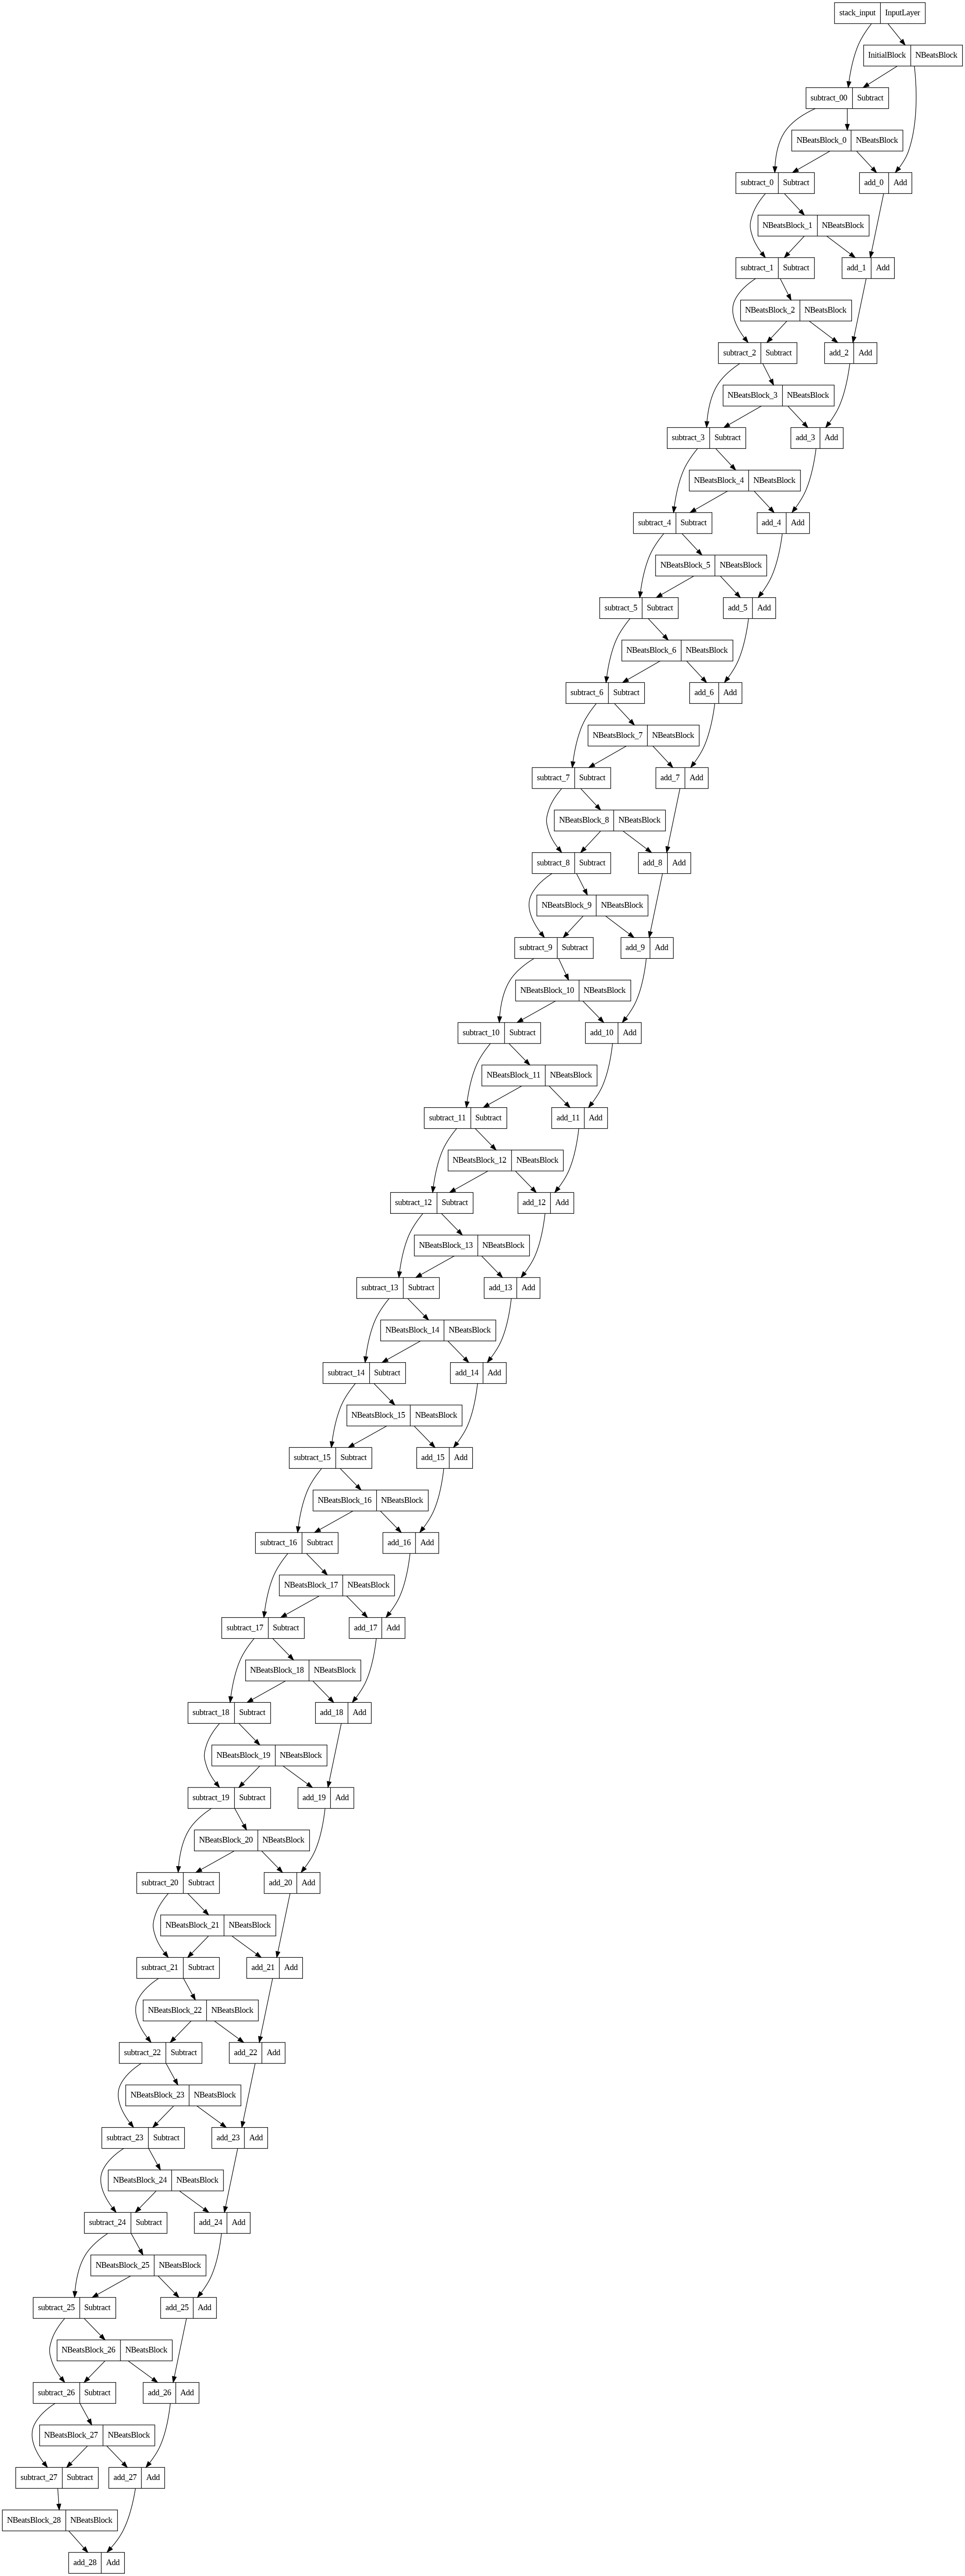

In [ ]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [ ]:
# Save model 7
model_7.save(model_7.name)

## Compare Models

We've trained a bunch of models.

And if anything, we've seen just how poorly machine learning and deep learning models are at forecasting the price of Bitcoin (or any kind of open market value).

To highlight this, let's compare the results of all of the modelling experiments we've performed so far.

In [ ]:
# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_results,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_7_NBEATs": model_7_results,
                              }).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1147547.000,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,564.261658,1152364.000,1073.482178,2.530578,0.991251
model_2_dense_w30_h1,615.597839,1333238.375,1154.659424,2.782414,1.076071
model_3_dense_w30_h7,1217.634521,5221397.000,1400.255005,5.472565,2.166713
model_4_CONV1D,574.423096,1191376.625,1091.501953,2.566289,1.009102
model_5_LSTM,586.206604,1237763.625,1112.548218,2.641489,1.029803
model_6_multivariate,570.325623,1182174.375,1087.278442,2.572218,1.001904
model_7_NBEATs,577.107544,1152439.750,1073.517456,2.606948,1.013818


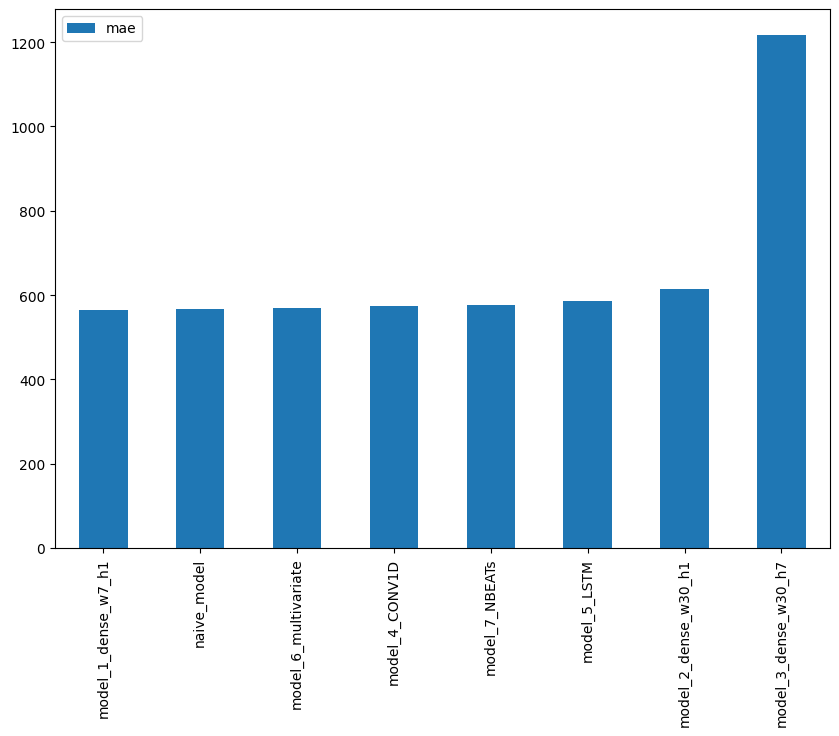

In [ ]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

It looks like the N-BEATS model doesn't perform as well as `model_1` or the original naive forecast.

This goes to show the power of smaller networks as well as the fact not all larger models are better suited for a certain type of data.